<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_02_auto_ml_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML

In [0]:
COLAB = True

In [17]:
if COLAB:
  !sudo apt-get install git-lfs && git lfs install
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  #!cd dl-projects && ls -l --block-size=M

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'dl-projects'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 757 (delta 76), reused 16 (delta 6), pack-reused 627
Receiving objects: 100% (757/757), 67.70 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (430/430), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [0]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display

from utils import *
from preprocess import *

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [21]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [22]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/"feature_matrix_2.csv"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/'4D.zip'

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 1151M
-rw------- 1 root root 407M Dec 30 05:00 feature_matrix_2.csv
-rw------- 1 root root 428M Dec 30 05:01 feature_matrix_2.pkl
-rw------- 1 root root 141M Dec 27 08:27 feature_matrix.csv
-rw------- 1 root root 176M Dec 27 08:28 feature_matrix.pkl
total 1M
-rw-r--r-- 1 root root 1M Jan  2 12:48 4D.txt
-rw-r--r-- 1 root root 1M Jan  2 12:48 4D.zip


In [0]:
data = pd.read_csv(DATASET, header=0, sep=',', quotechar='"', parse_dates=['time'])
origin_data = format_tabular(ORIGIN_DATASET)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699972 entries, 0 to 699971
Columns: 123 entries, index to year
dtypes: bool(3), datetime64[ns](1), float64(36), int64(83)
memory usage: 642.8 MB


## Exploratory Data Analysis

In [0]:
feature_matrix = data

In [27]:
feature_matrix.columns

Index(['index', 'NumberId', 'time', 'STD(Results.DrawNo)',
       'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
       'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MAX(Results.TotalStrike)', 'MIN(Results.DrawNo)',
       ...
       'LAST(Results.PrizeType)_SpecialNo2',
       'LAST(Results.PrizeType)_SpecialNo3',
       'LAST(Results.PrizeType)_SpecialNo4',
       'LAST(Results.PrizeType)_SpecialNo5',
       'LAST(Results.PrizeType)_SpecialNo6',
       'LAST(Results.PrizeType)_SpecialNo7',
       'LAST(Results.PrizeType)_SpecialNo8',
       'LAST(Results.PrizeType)_SpecialNo9', 'month', 'year'],
      dtype='object', length=123)

In [28]:
feature_matrix.head(4).T

,0,1,2,3
index,0,1,2,3
NumberId,0,1,2,3
time,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00
STD(Results.DrawNo),116257,96697.5,49525.7,116135
STD(Results.LuckyNo),0,0,0,0
...,...,...,...,...
LAST(Results.PrizeType)_SpecialNo7,0,0,0,0
LAST(Results.PrizeType)_SpecialNo8,0,0,0,0
LAST(Results.PrizeType)_SpecialNo9,1,0,0,0
month,1,1,1,1


In [55]:
origin_data[origin_data['LuckyNo']==911].head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo
10287,85495,1995-03-12,ConsolationNo3,911
13607,99896,1996-02-11,SpecialNo10,911
26564,156199,1999-08-29,SpecialNo9,911
30160,171800,2000-08-16,ConsolationNo4,911
65817,326909,2009-12-05,SpecialNo10,911
89716,430815,2015-10-07,SpecialNo3,911
96458,460117,2017-05-27,SpecialNo6,911
102733,487418,2018-12-08,SpecialNo2,911
104575,495419,2019-06-01,SpecialNo4,911
104910,496919,2019-07-03,ConsolationNo4,911


In [0]:
# feature_matrix.groupby('time')['COUNT(Results)'].mean().plot()
# plt.title('Average Monthly Count of Results')
# plt.ylabel('Strike Per Number')

## Feature Selection

In [31]:
from utils import feature_selection

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'NumberId']))

Original shape:  (699972, 121)
0 missing columns with threshold: 90.
22 zero variance columns.
27 collinear columns removed with threshold: 0.95.
Total columns removed:  49
Shape after feature selection: (699972, 72).


In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['NumberId'] = feature_matrix['NumberId']
feature_matrix_selection['Label'] = feature_matrix['Label']

In [34]:
feature_matrix_selection.columns

Index(['index', 'STD(Results.DrawNo)', 'MAX(Results.DrawNo)',
       'MAX(Results.LuckyNo)', 'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)',
       'SKEW(Results.DrawNo)', 'AVG_TIME_BETWEEN(Results.DrawDate)',
       'DAY(first_Results_time)', 'MONTH(first_Results_time)',
       'WEEKEND(first_Results_time)',
       'STD(Results.CUM_SUM(TotalStrike by NumberId))',
       'STD(Results.CUM_SUM(LuckyNo by NumberId))',
       'STD(Results.CUM_SUM(DrawNo by NumberId))',
       'STD(Results.CUM_MEAN(DrawNo by NumberId))',
       'MODE(Results.DAY(DrawDate))', 'MODE(Results.MONTH(DrawDate))',
       'MEAN(Results.CUM_MEAN(DrawNo by NumberId))',
       'SKEW(Results.CUM_SUM(LuckyNo by NumberId))',
       'SKEW(Results.CUM_SUM(DrawNo by NumberId))',
       'SKEW(Results.CUM_MEAN(DrawNo by NumberId))',
       'LAST(Results.DAY(DrawDate))', 'LAST(Results.MONTH(DrawDate))',
       'LAST(Results.WEEKEND(DrawDate))', 'TotalStrike',
       'MODE(Results.PrizeType)_1stPrizeNo',
       'MODE(Results.Pri

## Correlations

In [35]:
feature_matrix_selection.shape

(699972, 75)

In [36]:
corrs = feature_matrix_selection.corr().sort_values('TotalStrike')
corrs['TotalStrike'].head()

LAST(Results.DAY(DrawDate))              -0.012135
MODE(Results.PrizeType)_SpecialNo8       -0.003139
MODE(Results.PrizeType)_ConsolationNo9   -0.002791
index                                    -0.002659
LAST(Results.PrizeType)_SpecialNo8       -0.002540
Name: TotalStrike, dtype: float64

In [37]:
corrs['Label'].dropna().tail(8)

STD(Results.CUM_SUM(TotalStrike by NumberId))    0.002444
MEAN(Results.CUM_MEAN(DrawNo by NumberId))       0.002685
MODE(Results.PrizeType)_SpecialNo6               0.002528
MAX(Results.DrawNo)                              0.003222
MEAN(Results.DrawNo)                             0.003457
STD(Results.CUM_SUM(DrawNo by NumberId))         0.003707
Label                                            1.000000
TotalStrike                                      0.991613
Name: Label, dtype: float64

In [38]:
corrs['TotalStrike'].dropna().tail(8)

STD(Results.CUM_SUM(TotalStrike by NumberId))    0.002325
MEAN(Results.CUM_MEAN(DrawNo by NumberId))       0.002712
MODE(Results.PrizeType)_SpecialNo6               0.002818
MAX(Results.DrawNo)                              0.003362
MEAN(Results.DrawNo)                             0.003483
STD(Results.CUM_SUM(DrawNo by NumberId))         0.003656
Label                                            0.991613
TotalStrike                                      1.000000
Name: TotalStrike, dtype: float64

## Visualization

In [0]:
#pip install autoviz

In [0]:
#from autoviz.AutoViz_Class import AutoViz_Class

### XgBoost

In [0]:
import xgboost as xgb

In [0]:
model = xgb.XGBClassifier()

In [0]:
def predict_dt(dt, feature_matrix, return_probs = False):

    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   
    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Total positive
    positive = np.where((predictions==1))
    print('Total predicted to be positive: ', len(positive[0]))
  
    # Calculate metrics
    p = precision_score(y_test, predictions)
    r = recall_score(y_test, predictions)
    f = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, probs)
    a = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')
    print(f'Accuracy: {round(a, 5)}')

    #print('Probability')
    #print(len(probs), probs)

    # print('Probability >= Avg proba')
    # avg_p = np.average(probs)
    # print(f'Average probablity: {avg_p}')
    # hp = np.where((probs >= avg_p * 2) & (predictions==1) )
    # print(len(hp[0]), probs[hp[0]], hp[0])

    print('Confusion matrix')
    print(cm)

    # Total predicted matches
    print('Predicted matches')
    m = np.where((predictions==1))
    print(len(m[0]), m)

    if len(positive[0]) > 0:
      # Matching draws
      print('Matched draws')
      m = np.where((predictions==1) & (y_test == 1))
      print(len(m[0]), m)
      data = feature_matrix.loc[feature_matrix['date'] == dt]
      display(data.iloc[m[0]][
                              ['NumberId', 'Label', 'month', 'MODE(Results.PrizeType)_1stPrizeNo',
                                'MODE(Results.PrizeType)_2ndPrizeNo',
                                'MODE(Results.PrizeType)_3rdPrizeNo',
                                'MODE(Results.PrizeType)_ConsolationNo1',
                                'MODE(Results.PrizeType)_ConsolationNo10',
                                'MODE(Results.PrizeType)_ConsolationNo2',
                                'MODE(Results.PrizeType)_ConsolationNo3',
                                'MODE(Results.PrizeType)_ConsolationNo4',
                                'MODE(Results.PrizeType)_ConsolationNo5',
                                'MODE(Results.PrizeType)_ConsolationNo6',
                                'MODE(Results.PrizeType)_ConsolationNo7',
                                'MODE(Results.PrizeType)_ConsolationNo8',
                                'MODE(Results.PrizeType)_ConsolationNo9',
                                'MODE(Results.PrizeType)_SpecialNo1',
                                'MODE(Results.PrizeType)_SpecialNo10',
                                'MODE(Results.PrizeType)_SpecialNo2',
                                'MODE(Results.PrizeType)_SpecialNo3',
                                'MODE(Results.PrizeType)_SpecialNo4',
                                'MODE(Results.PrizeType)_SpecialNo5',
                                'MODE(Results.PrizeType)_SpecialNo6',
                                'MODE(Results.PrizeType)_SpecialNo7',
                                'MODE(Results.PrizeType)_SpecialNo8',
                                'MODE(Results.PrizeType)_SpecialNo9']].T)   
    else:
      print('No luck this month')                 

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi
    

In [44]:
# All the months
len(feature_matrix_selection['time'].unique()), feature_matrix_selection['time'].unique()

(70, array(['2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
        '2014-03-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
        '2014-05-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
        '2014-07-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
        '2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
        '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
        '2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
        '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
        '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
        '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
        '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
        '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
        '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
        '2016-03-01T00:00:00.00000

### Prediction by months

In [0]:
from utils import plot_feature_importances

In [79]:
%time dec_2018 = predict_dt(pd.datetime(2018,12,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 589972
Size of X train 589972
Size of X test  10000
Training on 589972 observations.
Testing on 10000 observations.

Total predicted to be positive:  0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.53153
Accuracy: 0.9641
Confusion matrix
[[9641    0]
 [ 359    0]]
Predicted matches
0 (array([], dtype=int64),)
No luck this month
CPU times: user 1min 51s, sys: 439 ms, total: 1min 52s
Wall time: 1min 52s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


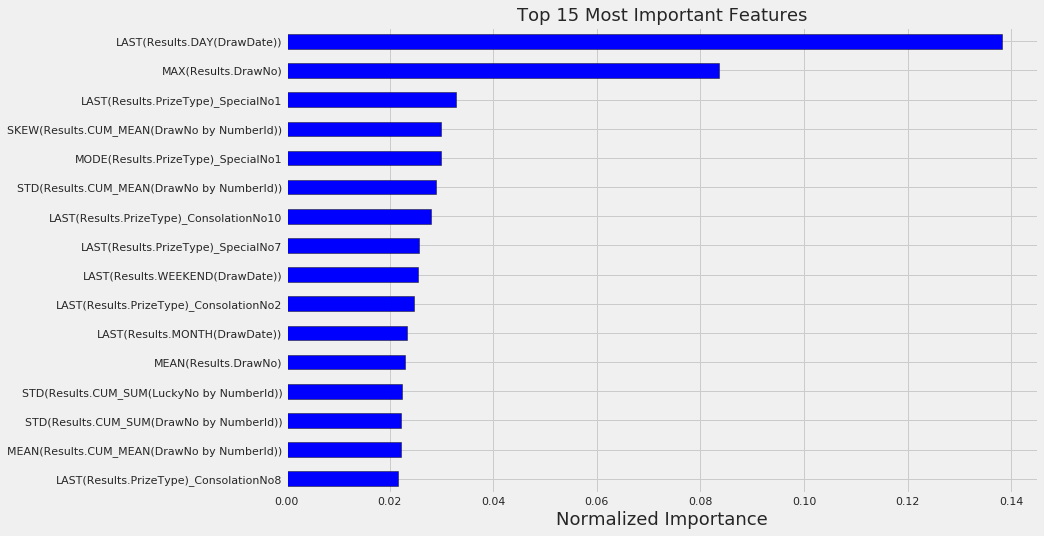

In [80]:
norm_dec_2018_fi = plot_feature_importances(dec_2018)

In [71]:
%time may_2019 = predict_dt(pd.datetime(2019,5,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 639972
Size of X train 639972
Size of X test  10000
Training on 639972 observations.
Testing on 10000 observations.

Total predicted to be positive:  0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.55018
Accuracy: 0.9704
Confusion matrix
[[9704    0]
 [ 296    0]]
Predicted matches
0 (array([], dtype=int64),)
No luck this month
CPU times: user 1min 59s, sys: 473 ms, total: 2min
Wall time: 2min


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


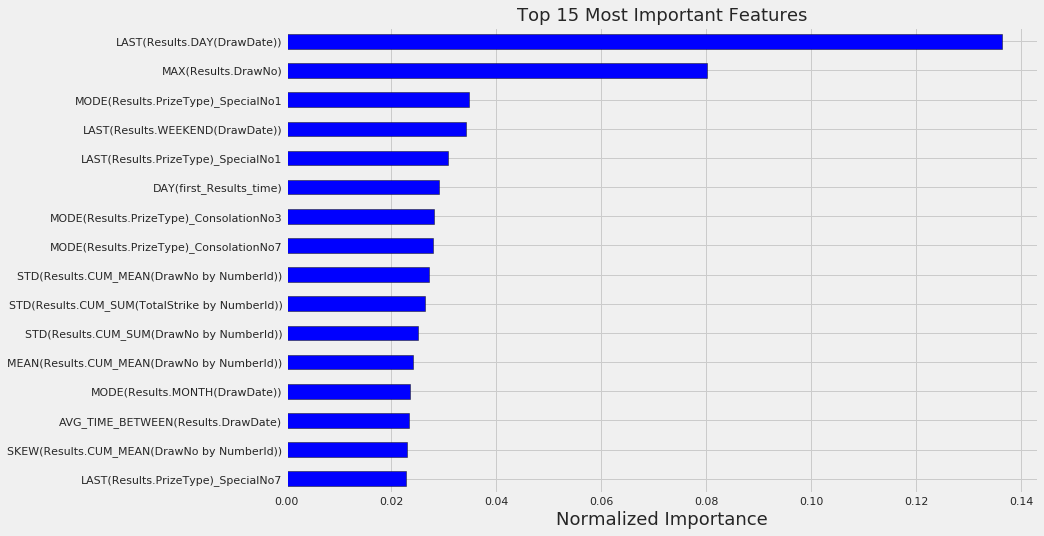

In [72]:
norm_may_2019_fi = plot_feature_importances(may_2019)

In [68]:
 %time june_2019 = predict_dt(pd.datetime(2019,6,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 649972
Size of X train 649972
Size of X test  10000
Training on 649972 observations.
Testing on 10000 observations.

Total predicted to be positive:  45
Precision: 0.51111
Recall: 0.06845
F1 Score: 0.12073
ROC AUC: 0.53672
Accuracy: 0.9665
Confusion matrix
[[9642   22]
 [ 313   23]]
Predicted matches
45 (array([ 128,  318,  511,  911,  992, 1271, 1661, 2006, 2089, 2106, 2222,
       2537, 2690, 2885, 2969, 2986, 3566, 3649, 3663, 3764, 4154, 4279,
       4336, 4626, 4633, 4649, 4664, 4738, 5687, 5916, 6127, 6246, 6547,
       6964, 7022, 7440, 7882, 8503, 8550, 8707, 8866, 9262, 9275, 9387,
       9627]),)
Matched draws
23 (array([ 128,  511,  911, 1661, 2006, 2089, 2537, 2885, 2969, 2986, 3566,
       3649, 4336, 4626, 4664, 4738, 5687, 5916, 6964, 7022, 7882, 8550,
       9275]),)


,650100,650483,650883,651633,651978,652061,652509,652857,652941,652958,653538,653621,654308,654598,654636,654710,655659,655888,656936,656994,657854,658522,659247
NumberId,128,511,911,1661,2006,2089,2537,2885,2969,2986,3566,3649,4336,4626,4664,4738,5687,5916,6964,7022,7882,8550,9275
Label,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
month,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
MODE(Results.PrizeType)_1stPrizeNo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MODE(Results.PrizeType)_2ndPrizeNo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
MODE(Results.PrizeType)_3rdPrizeNo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MODE(Results.PrizeType)_ConsolationNo1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
MODE(Results.PrizeType)_ConsolationNo10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MODE(Results.PrizeType)_ConsolationNo2,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
MODE(Results.PrizeType)_ConsolationNo3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


CPU times: user 2min 1s, sys: 472 ms, total: 2min 2s
Wall time: 2min 2s


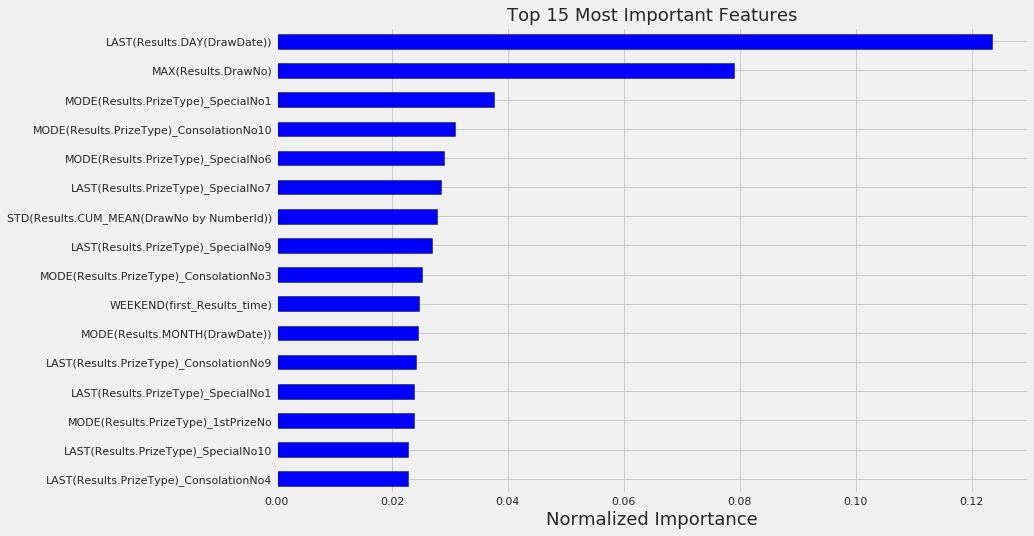

In [46]:
norm_june_2019_fi = plot_feature_importances(june_2019)

In [47]:
%time july_2019 = predict_dt(pd.datetime(2019,7,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 659972
Size of X train 659972
Size of X test  10000
Training on 659972 observations.
Testing on 10000 observations.

Total predicted to be positive:  23
Precision: 0.04348
Recall: 0.00318
F1 Score: 0.00593
ROC AUC: 0.50114
Accuracy: 0.9665
Probability >= Avg proba
Average probablity: 0.038568995893001556
23 [0.90061    0.89884794 0.924197   0.5285976  0.8618534  0.87345266
 0.8936415  0.86037385 0.844886   0.87182283 0.9234138  0.8816385
 0.9069439  0.86514425 0.8499653  0.9102114  0.884011   0.8590878
 0.92181545 0.92005885 0.5218596  0.9070102  0.83753383] [ 128  511  911  992 1661 2006 2089 2537 2885 2969 2986 3566 3649 4336
 4626 4664 4738 5687 5916 7882 8503 8550 9275]
Confusion matrix
[[9664   22]
 [ 313    1]]
Predicted matches
23 (array([ 128,  511,  911,  992, 1661, 2006, 2089, 2537, 2885, 2969, 2986,
       3566, 3649, 4336, 4626, 4664, 4738, 5687, 5916, 7882, 8503, 8550,
       9275]),)
Matched draws
1 (array([911]),)


,660883
index,660883
STD(Results.DrawNo),173181
MAX(Results.DrawNo),495419
MAX(Results.LuckyNo),911
MIN(Results.DrawNo),85495
...,...
month,7
time,2019-07-01 00:00:00
NumberId,911
Label,1


CPU times: user 2min 2s, sys: 583 ms, total: 2min 3s
Wall time: 2min 3s


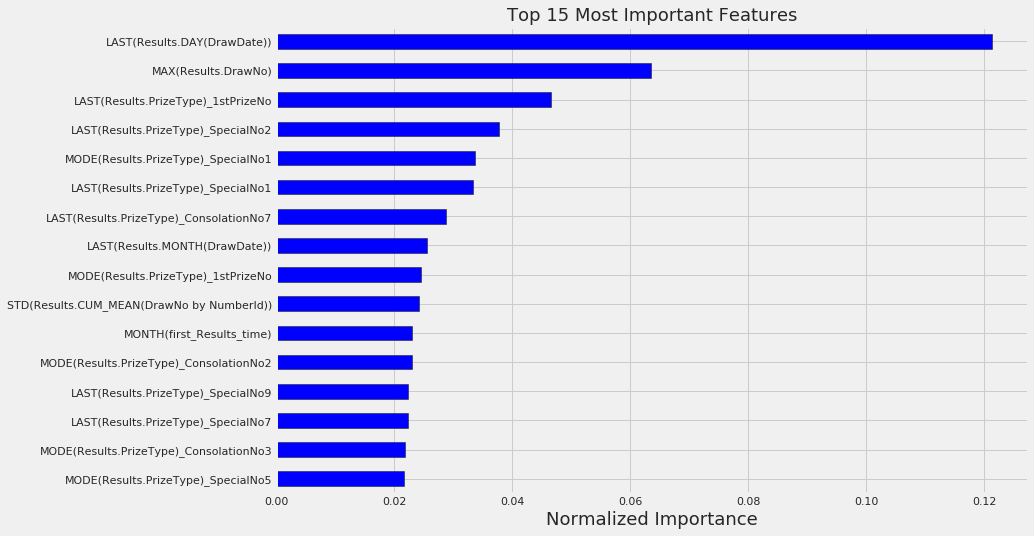

In [48]:
norm_july_2019_fi = plot_feature_importances(july_2019)

In [49]:
%time aug_2019 = predict_dt(pd.datetime(2019,8,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 669972
Size of X train 669972
Size of X test  10000
Training on 669972 observations.
Testing on 10000 observations.

Total predicted to be positive:  0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.51313
Accuracy: 0.9686
Probability >= Avg proba
Average probablity: 0.03529874235391617
0 [] []
Confusion matrix
[[9686    0]
 [ 314    0]]
Predicted matches
0 (array([], dtype=int64),)
No luck this month
CPU times: user 2min 7s, sys: 605 ms, total: 2min 7s
Wall time: 2min 7s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


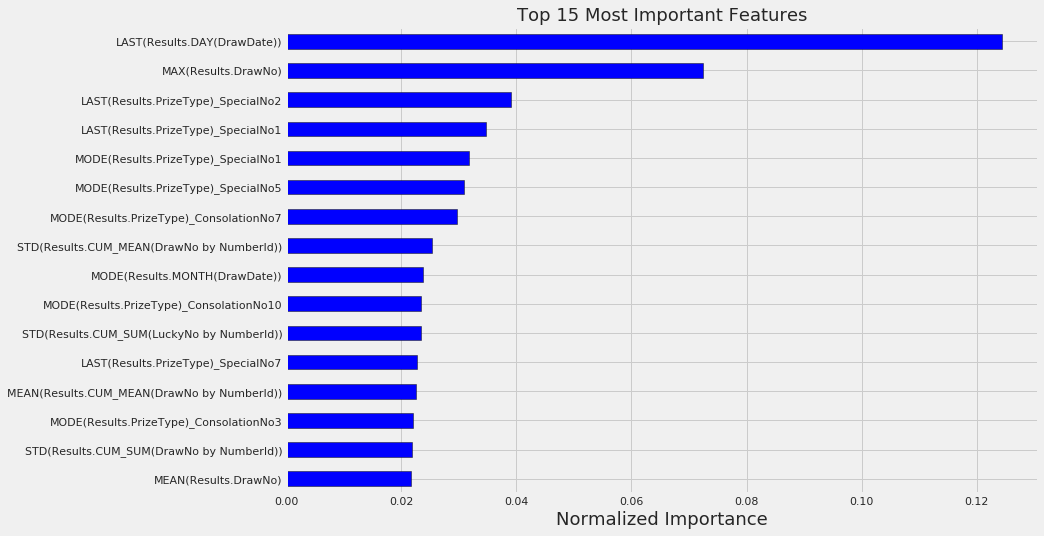

In [50]:
norm_aug_2019_fi = plot_feature_importances(aug_2019)

In [69]:
%time oct_2019 = predict_dt(pd.datetime(2019,10,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 689972
Size of X train 689972
Size of X test  10000
Training on 689972 observations.
Testing on 10000 observations.

Total predicted to be positive:  45
Precision: 0.51111
Recall: 0.07256
F1 Score: 0.12707
ROC AUC: 0.52853
Accuracy: 0.9684
Confusion matrix
[[9661   22]
 [ 294   23]]
Predicted matches
45 (array([ 502,  717,  851,  878, 1069, 1311, 1574, 1781, 1800, 1836, 2524,
       2731, 2917, 3162, 3192, 3246, 3399, 3425, 3499, 3791, 3926, 4418,
       4483, 4600, 4719, 4785, 4809, 5091, 5702, 5806, 6780, 6958, 7129,
       7344, 7714, 7911, 8171, 8900, 8993, 9001, 9520, 9682, 9691, 9808,
       9864]),)
Matched draws
23 (array([ 502,  717, 1069, 1781, 1836, 2917, 3162, 3399, 4418, 4483, 4600,
       4785, 4809, 5702, 6958, 7129, 7344, 7911, 8993, 9520, 9691, 9808,
       9864]),)


,690474,690689,691041,691753,691808,692889,693134,693371,694390,694455,694572,694757,694781,695674,696930,697101,697316,697883,698965,699492,699663,699780,699836
NumberId,502,717,1069,1781,1836,2917,3162,3399,4418,4483,4600,4785,4809,5702,6958,7129,7344,7911,8993,9520,9691,9808,9864
Label,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
month,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
MODE(Results.PrizeType)_1stPrizeNo,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
MODE(Results.PrizeType)_2ndPrizeNo,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
MODE(Results.PrizeType)_3rdPrizeNo,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
MODE(Results.PrizeType)_ConsolationNo1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
MODE(Results.PrizeType)_ConsolationNo10,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
MODE(Results.PrizeType)_ConsolationNo2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
MODE(Results.PrizeType)_ConsolationNo3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


CPU times: user 2min 10s, sys: 467 ms, total: 2min 10s
Wall time: 2min 10s


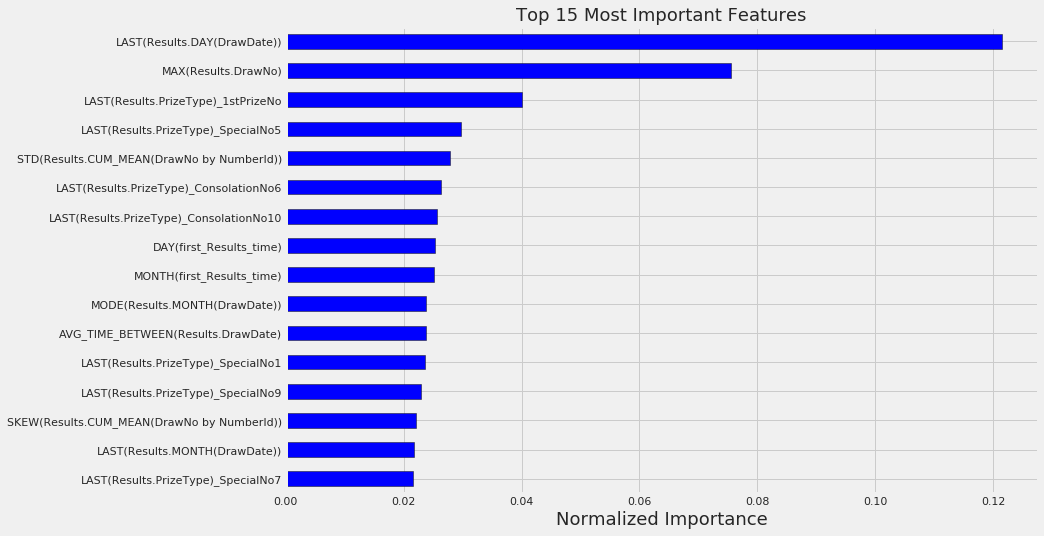

In [52]:
norm_oct_2019_fi = plot_feature_importances(oct_2019)

## Tuning - GridSearchCV

## Check Raw Data

## Testing

In [53]:
import numpy as np
import pandas as pd

data = [['no_1', 1], ['no_2', 2], ['no_3', 3], ['no_4', 4], ['no_5', 5], ['no_6', 6], ['no_7', 7]] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Name', 'Age']) 

a = np.array([0,0,0,1,0,1, 1])
b = np.array([0,0,0,1,0,0, 1])

print(len(a))
m = np.where((a==1) & (b ==1))
print(len(m[0]), m[0], a[m[0]])
print(df.iloc[m[0]])

7
2 [3 6] [1 1]
   Name  Age
3  no_4    4
6  no_7    7


In [54]:
probs = np.array([0.03399902, 0.03295987, 0.03078781, 0.04921166, 0.03662422, 0.03233755])
print(np.average(probs))

0.03598668833333333


In [66]:
mydict = [{'a': 1, 'b': 2, 'c': 3, 'd': 4},
         {'a': 100, 'b': 200, 'c': 300, 'd': 400},
         {'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000 }]
df = pd.DataFrame(mydict)
df.iloc[[0]][['a','b']]

,a,b
0,1,2
